# Imports

In [63]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt


mpl_rc = "../assets/matplotlibrc"
plt.style.use(mpl_rc)
import numpy as np
import pickle
import brian2 as b2
from automind.sim import b2_inputs
from automind.utils import data_utils, dist_utils, plot_utils
from brian2 import *
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import accuracy_score
from scipy.stats import kendalltau
from scipy.stats import linregress


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_dirs = "../datasets/discovered_posterior_samples/synthetic/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)

posterior.pickle ['7149324_posterior.pickle']
params_dict_analysis_updated.pickle ['7149324_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['7149324_MK1_summary_data_merged.csv']
1003 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [12]:
f_bounds = posterior.x_bounds_and_transforms["freq_bounds"]
print(f"Density estimator was trained on PSD between {f_bounds} Hz.")

# Extract the frequency bounds and trim correspondingly
freqs = data_utils.decode_df_float_axis(cols_psd)
f_idx = (freqs >= f_bounds[0]) & (freqs <= f_bounds[1])
freqs, cols_features = freqs[f_idx], np.array(cols_psd)[f_idx]

Density estimator was trained on PSD between (0.5, 495) Hz.


# Picking the observation and samples

In [10]:
observation_indices = df_xos[df_xos['inference.type']=='gt_resim'].index.tolist()

In [ ]:
#Run this instead if you manually selected the samples instead of resampling 
id = 10030 #Gamma 
n_samples = 50
xo = df_xos.iloc[id][cols_features].values 
samples = df_xos.iloc[id:][cols_features].values
log_samples = True
stdz_func = posterior.x_standardizing_func
standardised_samples = dist_utils.log_n_stdz(samples,stdz_func)
include_mapnmean = True
sort_samples=True
sort_weights=((freqs>=50) & (freqs<=400)) #Filter unwanted frequencies 

samples_sorted, dists, idx_sorted = dist_utils.sort_closest_to_xo(
                    standardised_samples[0,:], standardised_samples, "mse",top_n=None, weights=sort_weights
                )

params_dict['params_settings']['sim_time'] = 60.1 * b2.second #Changing simulation time to 60 seconds 
df_samples = df_xos.iloc[id+idx_sorted[0:n_samples+1]] #Top x samples closest to the "true" oscillation
df_samples = df_samples.iloc[:,3:33] #Only network information (or else unwanted info will be passed to fill_params_dict)


WARNING    c:\users\brian.laptop-8bs4kr2p\automind\automind\utils\dist_utils.py:428: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(samples)
 [py.warnings]
WARNING    c:\users\brian.laptop-8bs4kr2p\automind\automind\utils\dist_utils.py:463: RuntimeWarning: invalid value encountered in multiply
  dist = (dists * weights).mean(1)
 [py.warnings]


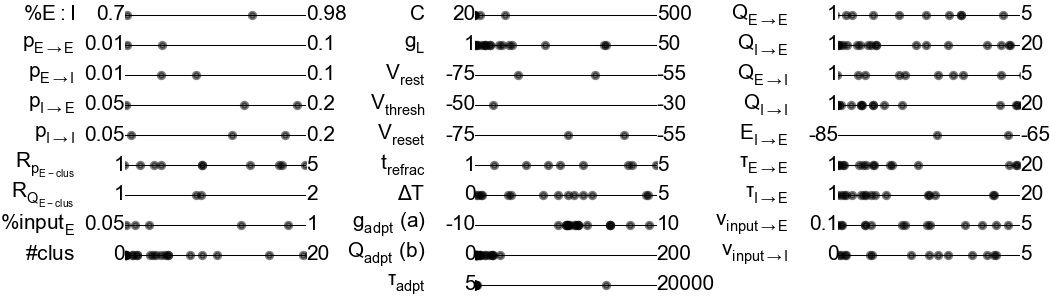

In [14]:
from automind.sim.default_configs import MKI_pretty_param_names

_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5, 1))
plot_utils.plot_params_1D(
    np.array([df_samples[posterior.names].values]),
    theta_minmax,
    MKI_pretty_param_names,
    (fig, axs),
    color="k",
    draw_canvas=True,
    draw_kde=False,
    draw_samples=True,
    labelpad=12,
    draw_median=False,
    sample_ms=3,
    sample_alpha=0.5,
);

In [15]:
#Data paths 
single_exc_path = "../results/single_exc_rates.pkl"
single_inh_path = "../results/single_inh_rates.pkl"
cont_exc_path = "../results/cont_exc_rates.pkl"
cont_inh_path = "../results/cont_inh_rates.pkl"
sum_features_path = "../results/summary_features.pkl"

In [ ]:
#Loading data 
with open(single_exc_path, 'rb') as f:
    single_exc = pickle.load(f)
with open(single_inh_path, 'rb') as f:
    single_inh = pickle.load(f)
with open(cont_exc_path, 'rb') as f:
    cont_exc = pickle.load(f)
with open(cont_inh_path, 'rb') as f:
    cont_inh = pickle.load(f)
with open(sum_features_path, 'rb') as f:
    sum_features = pickle.load(f)

In [ ]:
#Removing the last timepoint - only run once

print(np.shape(single_exc))
single_exc = single_exc[:,:,:,:-1] 
single_inh = single_inh[:,:,:,:-1] 
print(np.shape(single_exc)) # (n_networks,n_inputs,n_neurons,n_timepoints) -> timepoints have already been downsampled 

(50, 25, 200, 2000)


Text(0.5, 0, 'time (s)')

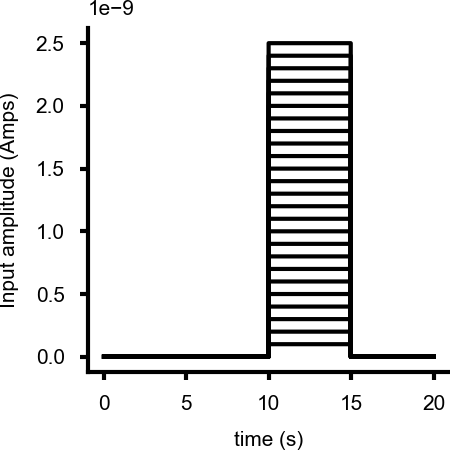

In [ ]:
#Inputs 
strengths = np.linspace(0.1,2.5,25)
for strength in strengths: 
    plt.plot(np.linspace(0,20,100166),b2_inputs.DM_simple(params_dict,strength*10**-9,0)[:100166],c='black') #Standard deviation set to 0 for visualisation 
plt.ylabel("Input amplitude (Amps)")
plt.xlabel("time (s)")


In [ ]:
#Taking meaningful periods 

input_period_exc_FR = single_exc[:,:,:,1000:1500]
input_period_inh_FR = single_inh[:,:,:,1000:1500]

refractory_period_exc_FR = single_exc[:,:,:,1500:]
refractory_period_inh_FR = single_inh[:,:,:,1500:]

input_period_1s_exc = single_exc[:,:,:,1200:1300]
input_period_1s_inh = single_inh[:,:,:,1200:1300]

input_period_first_exc = single_exc[:,:,:,1000:1100]
input_period_first_inh = single_inh[:,:,:,1000:1100]

In [22]:
#Average across neurons 
pop_input = np.mean(input_period_exc_FR,axis=2)
pop_refrac = np.mean(refractory_period_exc_FR,axis=2)

#Maximum responses in different conditions 
max_input_all = np.zeros((50,25))
avg_refrac_all = np.zeros((50,25))
avg_input_all = np.zeros((50,25))
for i in range(50):
    for j in range(25):
        max_input_all[i,j] = np.max(pop_input[i,j])
        avg_input_all[i,j] = np.mean(pop_input[i,j])
        avg_refrac_all[i,j] = np.mean(pop_refrac[i,j])

WARNING    C:\Users\brian.LAPTOP-8BS4KR2P\AppData\Local\Temp\ipykernel_28148\35586188.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


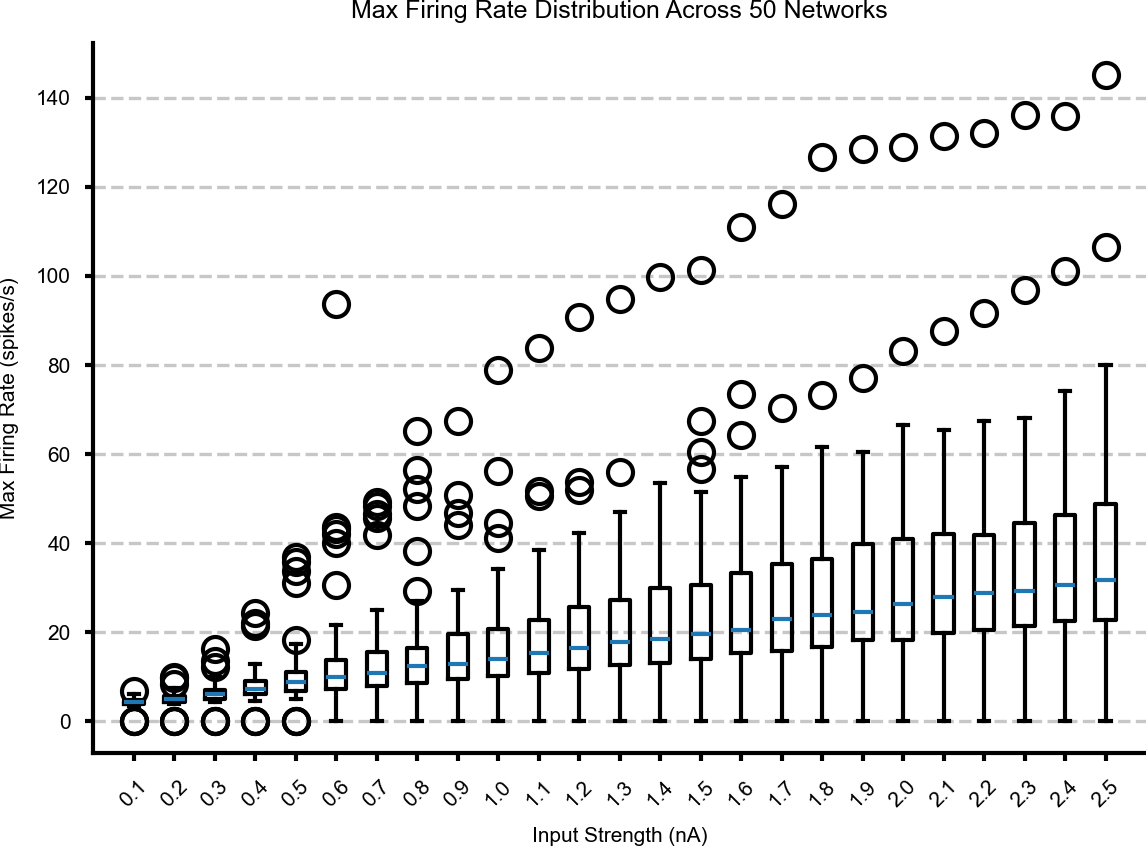

In [ ]:
#Range of maximum firing rates excluding exploded networks 

input_strengths = np.linspace(0.1, 2.5, 25)
# Apply filtering: Exclude values > 200 
filtered_data = [max_input_all[max_input_all[:, i] < 150, i] for i in range(25)]

# Create boxplots
plt.figure(figsize=(4,3))
plt.boxplot(filtered_data, positions=input_strengths, widths=0.05)  # Set positions to match input strengths

# Set labels
plt.xlabel("Input Strength (nA)", fontsize=5)
plt.ylabel("Max Firing Rate (spikes/s)", fontsize=5)
plt.title("Max Firing Rate Distribution Across 50 Networks", fontsize=6)

# Format x-ticks to round to 1 decimal place
plt.xticks(input_strengths, [f"{x:.1f}" for x in input_strengths], rotation=45)
plt.xlim(min(input_strengths) - 0.1, max(input_strengths) + 0.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


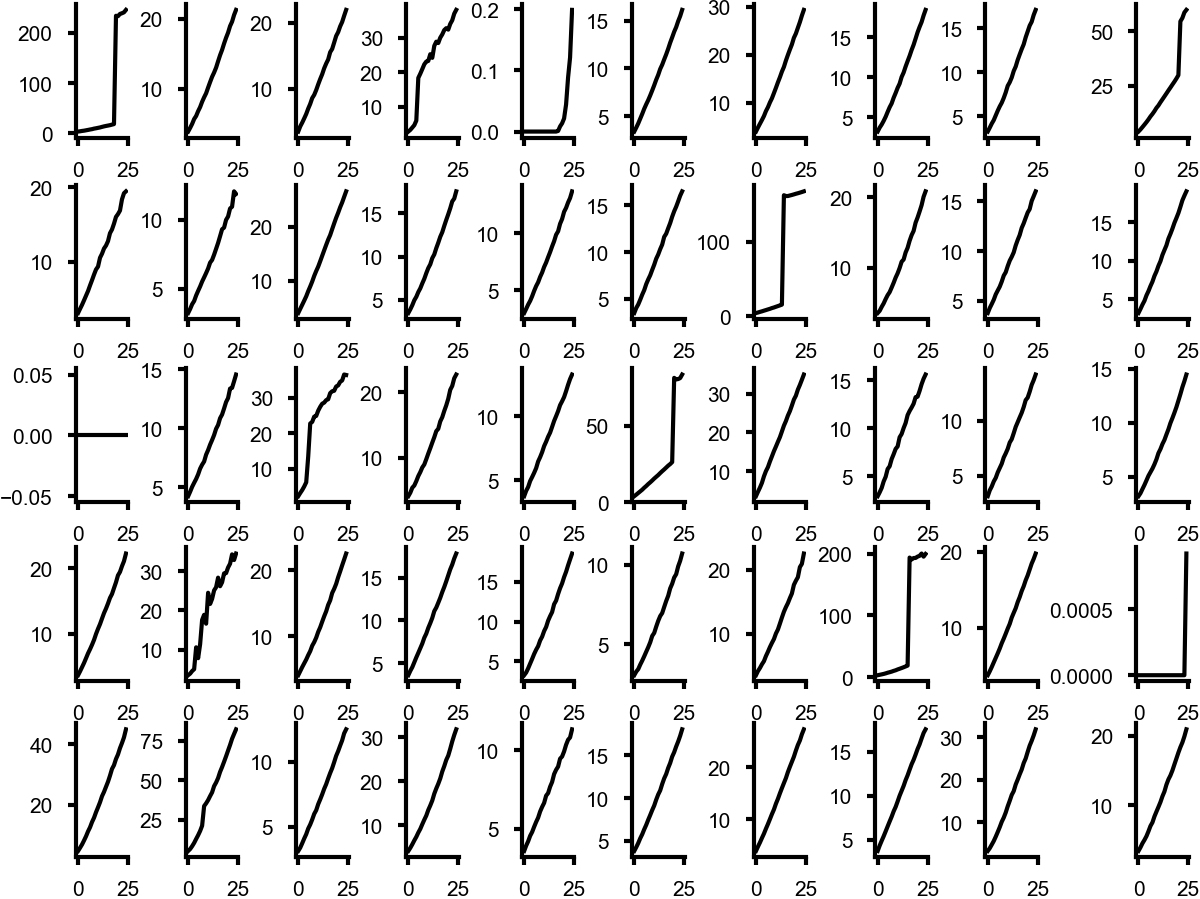

In [26]:
#Input output relation of all 50 networks 
fig, ax = plt.subplots(5,10,figsize=(4,3))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].plot(avg_input_all[i])

WARNING    C:\Users\brian.LAPTOP-8BS4KR2P\AppData\Local\Temp\ipykernel_28148\2994431667.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


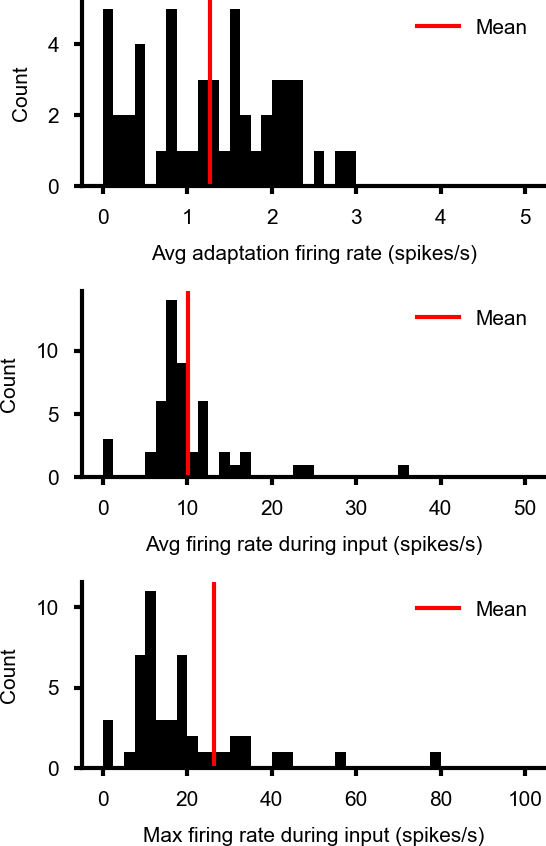

In [ ]:
fig, axes = plt.subplots(3, figsize=(2,3))
#Histogram of responses to 1nA input 

avg_refrac = avg_refrac_all[:,9]
avg_input = avg_input_all[:,9]
max_input = max_input_all[:,9]

# Plot avg_refrac histogram
axes[0].hist(avg_refrac, bins=np.linspace(0, 5, 41))
axes[0].axvline(np.mean(avg_refrac), c='red', label="Mean")
axes[0].set_xlabel("Avg adaptation firing rate (spikes/s)")
axes[0].set_ylabel("Count")
axes[0].legend()

# Plot avg_input histogram
axes[1].hist(avg_input, bins=np.linspace(0, 50, 41))
axes[1].axvline(np.mean(avg_input), c='red', label="Mean")
axes[1].set_xlabel("Avg firing rate during input (spikes/s)")
axes[1].set_ylabel("Count")
axes[1].legend()

# Plot max_input histogram
axes[2].hist(max_input, bins=np.linspace(0, 100, 41))
axes[2].axvline(np.mean(max_input), c='red', label="Mean")
axes[2].set_xlabel("Max firing rate during input (spikes/s)")
axes[2].set_ylabel("Count")
axes[2].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Input strength (Amps)')

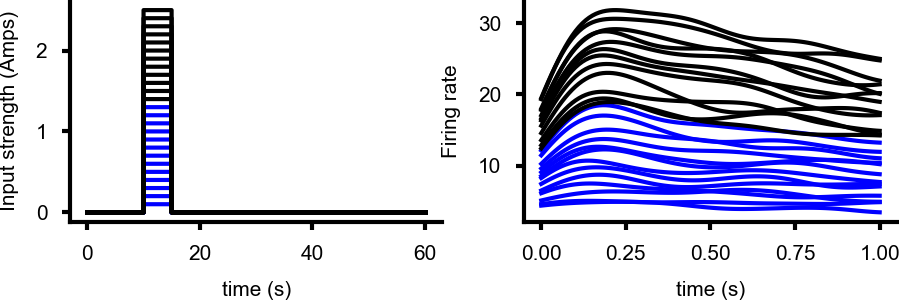

In [ ]:
#Train stimuli and initial (1 second) response 
fig, ax = plt.subplots(1,2,figsize=(3,1))
sim_time = params_dict['params_settings']['sim_time']
for i in range(25):
    ax[0].plot(np.linspace(0,sim_time, len(b2_inputs.DM_simple(params_dict,strengths[i]))), b2_inputs.DM_simple(params_dict,strengths[i]), c='blue' if i<13 else 'black')
    ax[1].plot(np.linspace(0,1,100),np.mean(input_period_first_exc[1],axis=1)[i,:], color="blue" if i<13 else "black")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("Firing rate")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("Input strength (Amps)")


In [31]:
#Downsampling input for analysis 
test_input = b2_inputs.test_stim(params_dict)

def downsample_signal(stim, target_length):
    downsample_factor = len(stim) // target_length
    
    downsampled_stim = stim[::downsample_factor]
    
    return downsampled_stim

stim_downsampled = downsample_signal(test_input[:300000], 6000)
mask = [1 if i>0.5*np.max(stim_downsampled) else 0 for i in stim_downsampled]
stim_loc = np.where(stim_downsampled>0)[0]

In [ ]:
#Find input periods for sliding window 
window_size = 50 
input_period = np.array([1 if i>0 else 0 for i in stim_downsampled])
prediction_mask = np.zeros(5951) 

for i in range(0, len(input_period) - window_size + 1):
    window = input_period[i:i + window_size]
    features = np.mean(window)
    if features==1:
        prediction_mask[i] = 1
stim_loc_slide = np.where(prediction_mask==1)[0] #Locations where sliding window is fully within the stim-on period 
single_pulse_length_slide = len(stim_loc_slide)/25 #Length of an input pulse 
ground_truth = np.zeros(len(stim_loc_slide))
ground_truth[int(single_pulse_length_slide*12):] = 1 #Starting from the 13th input the input should be above half of the maximum


In [35]:
#Calculating decoding accuracy 
decode_probabilities = []
accuracies = np.zeros(n_samples)
for i in range(n_samples):
    decoder = b2_inputs.NeuralDecoder(method='logistic')
    decoder.train(input_period_first_exc[i],np.linspace(10**-10, 2.5*10**-9, 25))
    prediction, probability = decoder.predict(cont_exc[i], use_sliding_window=True, window_size=50)
    accuracies[i] = accuracy_score(ground_truth,prediction[stim_loc_slide])
    decode_probabilities.append(probability[stim_loc_slide])
    
    

Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.84
Cross-validated accuracy using logistic: 0.40
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 1.00
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 1.00
Cross-validated accuracy using logistic: 1.00
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.92
Cross-validated accuracy using logistic: 1.00
Cross-validated accuracy using logistic: 0.92
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.92
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.96
Cross-validated accuracy using logistic: 0.40
Cross-validated accuracy using log

In [36]:
#Average decoding probability across different sliding windows throughout the input period 
average_probabilities = np.zeros((50,25))
for i in range(50):
    for j in range(25):
        average_probabilities[i,j] = np.mean(decode_probabilities[i][int(j*single_pulse_length_slide):int((j+1)*single_pulse_length_slide)])

In [37]:
#Kendall's tau of each network's decoding probability across different input strengths
tau = np.array([kendalltau(average_probabilities[i].reshape(-1,1),strengths) for i in range(50)])


Text(-0.01, 0.5, 'Decoding probability')

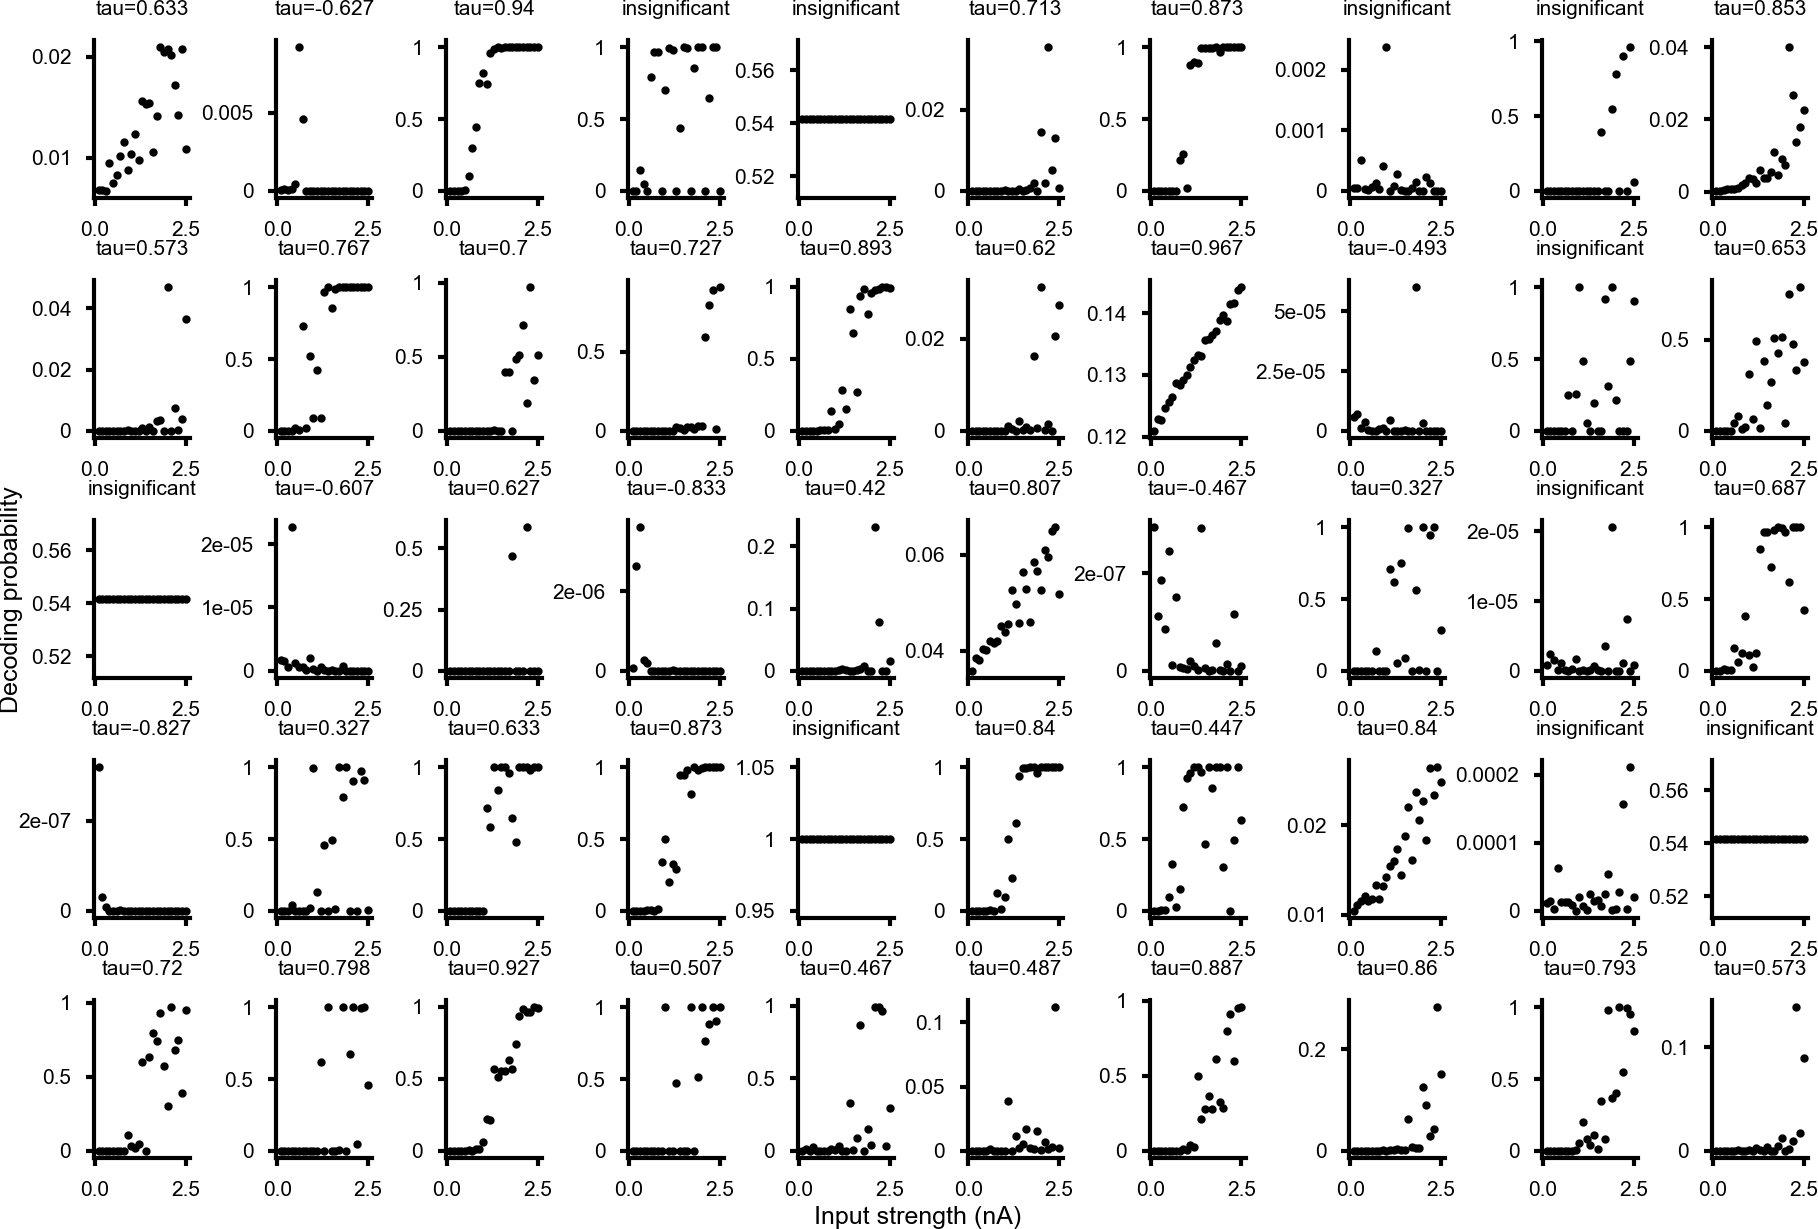

In [ ]:
#Decoding probability against input strength for the 50 networks 
import matplotlib.ticker as ticker
def format_func(value, tick_number):
    return f"{value:.3g}"  # Formats to 3 significant figures

fig, ax = plt.subplots(5, 10, figsize=(6, 4))
ax = ax.flatten()

for i in range(50):
    ax[i].scatter(strengths, average_probabilities[i], s=1)
    ax[i].set_title(f'tau={np.round(tau[i,0],3)}' if tau[i,1] < 0.05 else 'insignificant')
    ax[i].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax[i].yaxis.get_major_formatter().set_powerlimits((-3, 3))
    ax[i].yaxis.get_major_formatter().set_useOffset(False)
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    
fig.text(0.5, -0.02, "Input strength (nA)", ha='center', fontsize=6)
fig.text(-0.01, 0.5, "Decoding probability", va='center', rotation='vertical', fontsize=6)



WARNING    C:\Users\brian.LAPTOP-8BS4KR2P\AppData\Local\Temp\ipykernel_28148\318072433.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


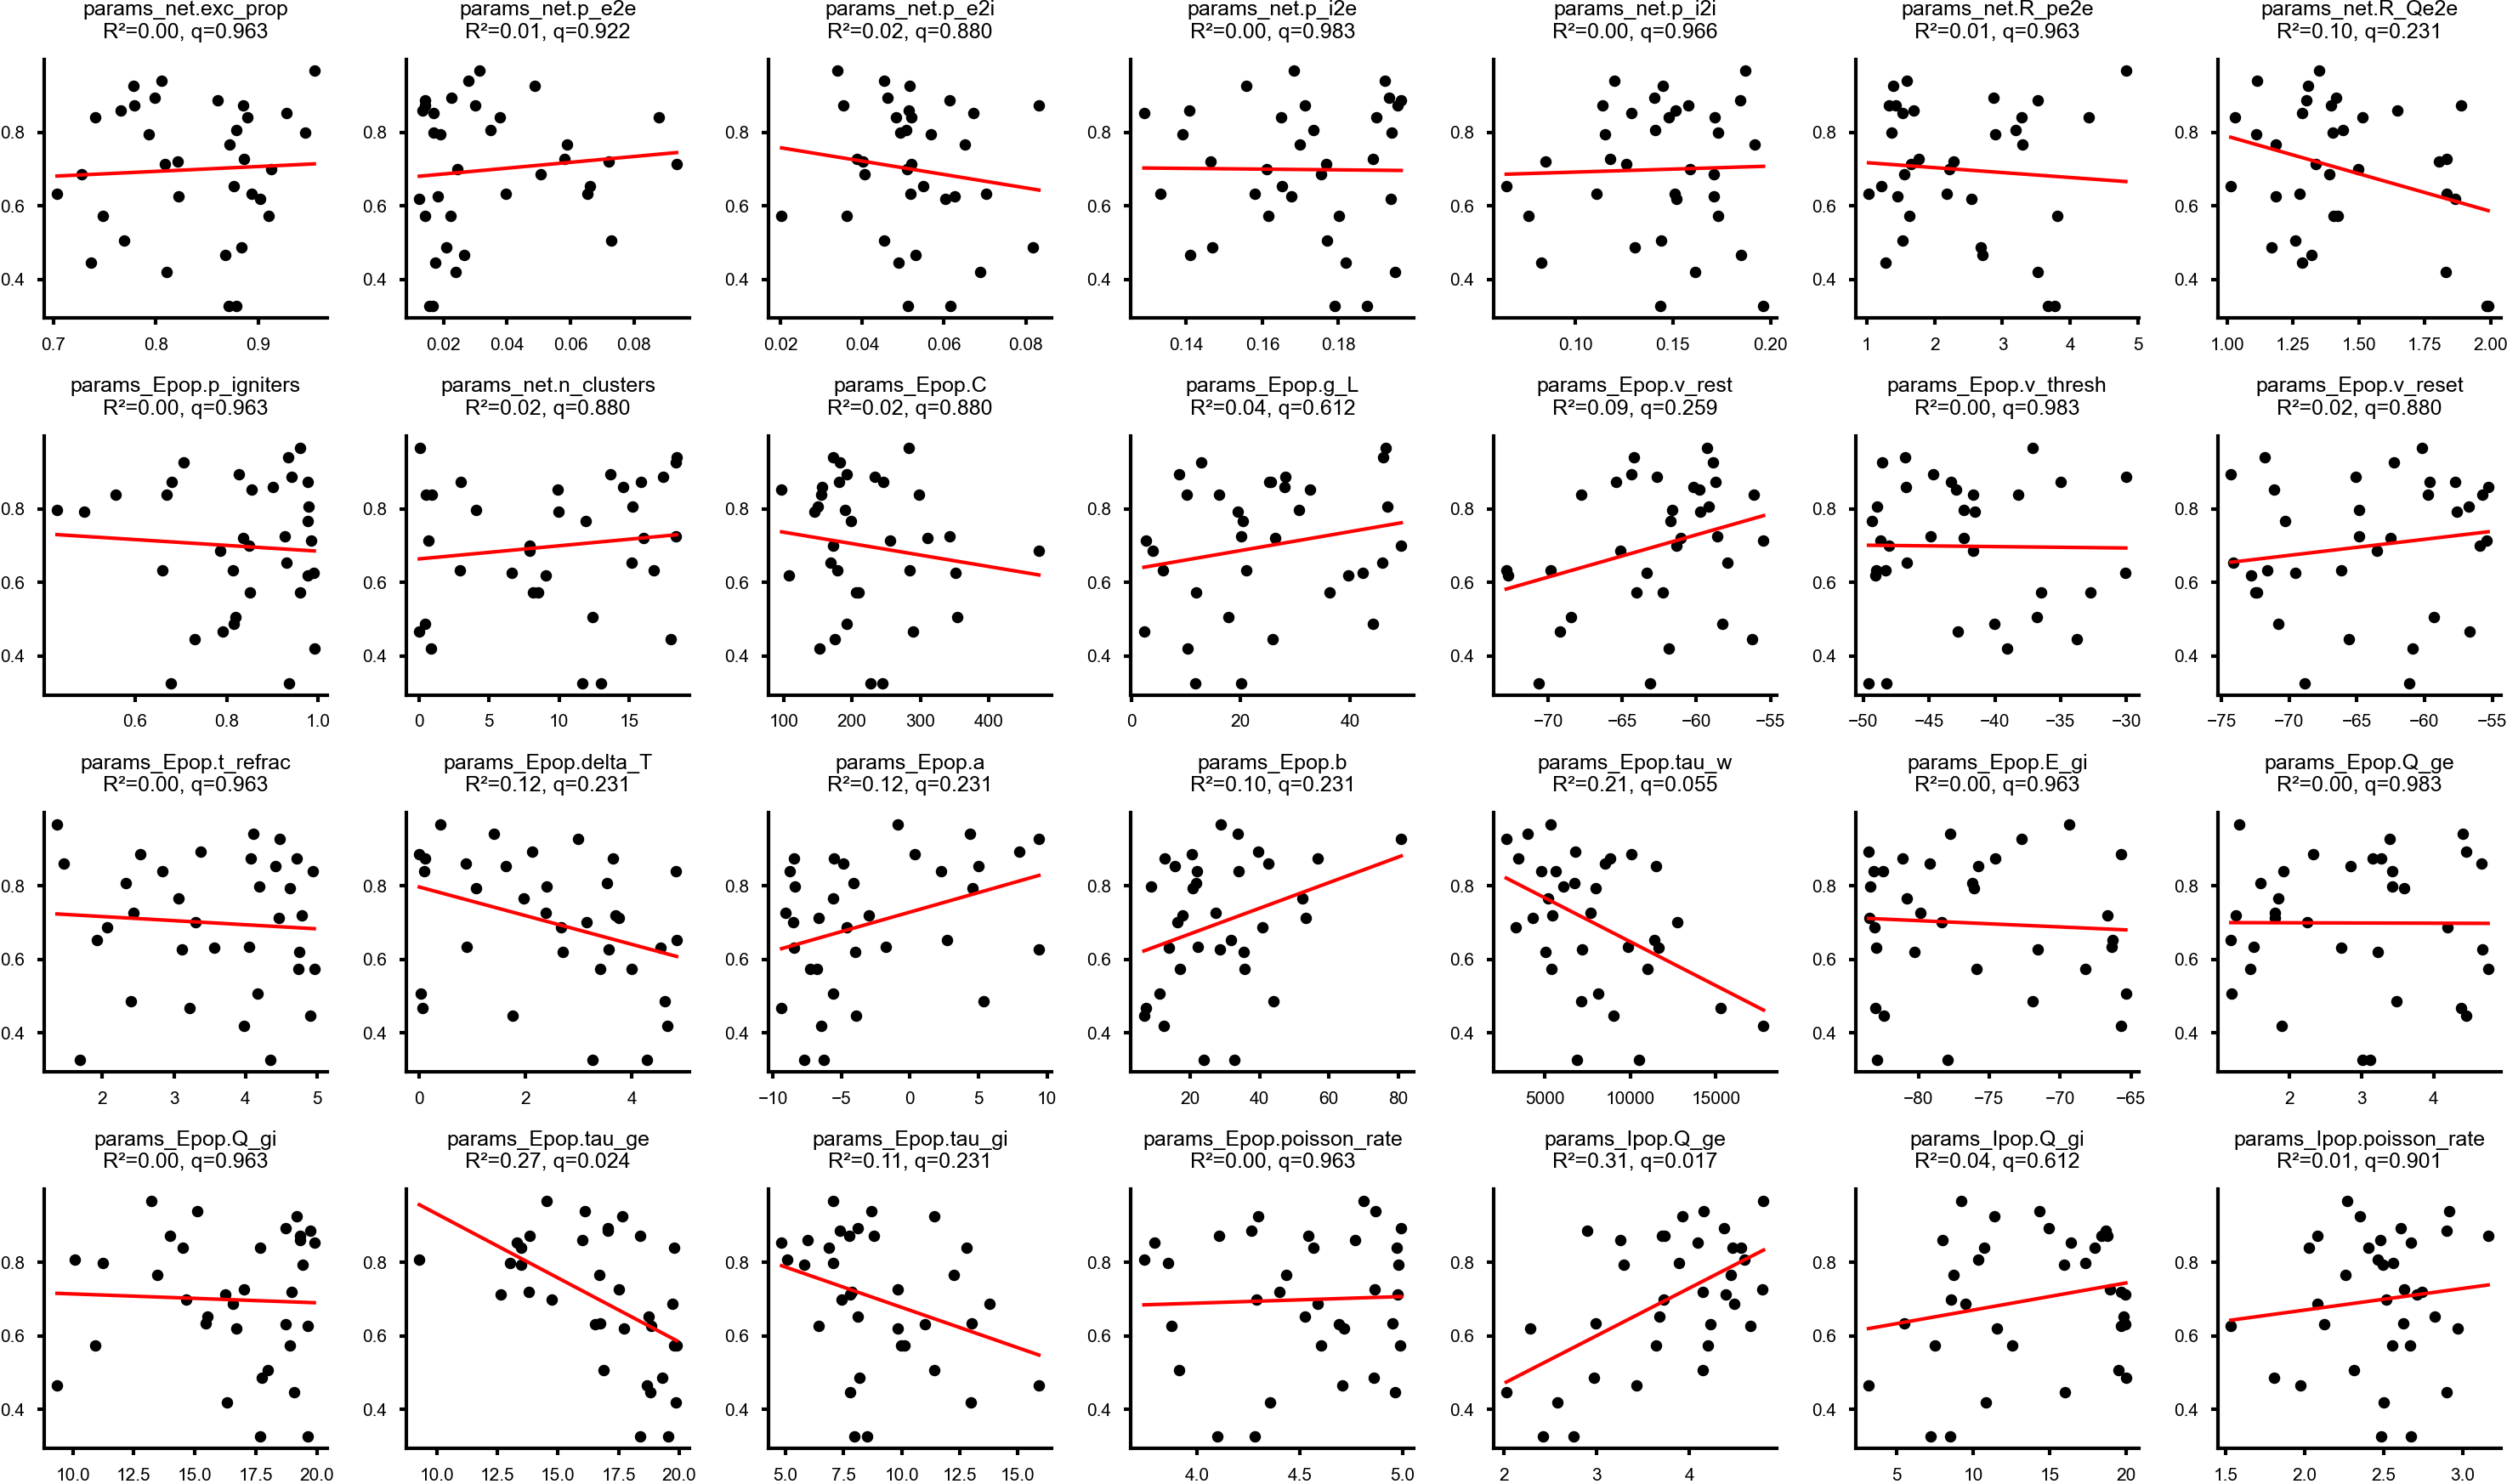

In [61]:
fig, ax = plt.subplots(4, 7, figsize=(10, 6)) 
ax = ax.flatten()

regression_pvals = []
r2_scores = []

#perform linear regressions and collect p-values
for i, param in enumerate(df_samples.columns[2:]):
    mask = np.logical_and(tau[:, 1] < 0.05, tau[:, 0] > 0)
    x = df_samples[param][:-1][mask].values
    y = tau[:, 0][mask]

    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        regression_pvals.append(p_value)
        r2_scores.append(r_value**2)
    else:
        regression_pvals.append(1.0)  # Add non-significant p if insufficient data
        r2_scores.append(np.nan)

# Apply FDR correction
_, pvals_fdr, _, _ = multipletests(regression_pvals, alpha=0.05, method='fdr_bh')

#plot with FDR-corrected p-values
for i, param in enumerate(df_samples.columns[2:]):
    mask = np.logical_and(tau[:, 1] < 0.05, tau[:, 0] > 0)
    x = df_samples[param][:-1][mask].values
    y = tau[:, 0][mask]

    if len(x) > 1:
        ax[i].scatter(x, y, s=5)
        slope, intercept, _, _, _ = linregress(x, y)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = slope * x_fit + intercept
        ax[i].plot(x_fit, y_fit, color='red', linewidth=1)
        ax[i].set_title(f"{param}\nR²={r2_scores[i]:.2f}, q={pvals_fdr[i]:.3f}", fontsize=6)
    else:
        ax[i].set_title(f"{param}\nInsufficient data", fontsize=6)

plt.tight_layout()
